In [27]:
import gmsh
import numpy as np
import pyvista
import dolfinx
from petsc4py.PETSc import ScalarType 
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import basix
import ufl


**B1.1 State and give a brief description of the basic steps for solving the Poisson equation using the FEM**




*   We define the equation (Poisson)
*   We define the boundary conditions
*   We decide on basis and test functions to use
*   The equation and boundary conditions are reformulated into a weak form
*   The weak form is discretised onto the mesh, represented by a combination of basis functions
*   We construct a linear system of equations from the above, applying the boundary conditions
*   Then, we can solve the linear system

**B1.2 What are the element and the assembly matrices? What is the relation between the element and assembly matrices?**

The element matrix is a matrix representing a single element, being constructed from a set of nodes. The assembly matrix is constructed from the element matrixes.

**B1.3 Use either a modified version of the code from the slides or some of the other tools shown during the lecture to create a suiting mesh.**

**B1.3.2 What are two data structures used for storing information about the mesh? What are the numbers of elements and nodes in the mesh? How is it found? HINT: study mesh.geometry.**
The two data structures used to represent the matrix are the el2no and no2xy matrices. The former represents each element as a sequence of nodes. The latter stores information about the x and y coordinates for each node.





In [28]:
gmsh.initialize()
model = gmsh.model()
print(MPI.COMM_WORLD)
mesh_comm = MPI.COMM_WORLD
model_rank = 0
srfc = 6
if mesh_comm.rank == model_rank:
  square = model.occ.addRectangle(0,0,0,1,1)
  # square = model.occ.addDisk(0, 0, 0, 1, 1)

  circle = model.occ.addDisk(0, 0, 0, 0.5, 0.5)
  model_dim_tags = model.occ.cut([(2, square)],[(2, circle)])

  target_geometry = model_dim_tags[0][0]
  model.occ.synchronize()
  model.addPhysicalGroup(2, [square])
  #print(model_dim_tags)
  #model.add_physical_group(2, [square])
  model.mesh.generate(2)

  # Problem line
  #msh, mt, ft
  msh, cell_tags, facet_tags = dolfinx.io.gmshio.model_to_mesh(model, mesh_comm, model_rank)
  print(msh)
gmsh.finalize()


Info    : Meshing 1D...                                                                                      
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00230908s, CPU 0.000181s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00458913s, CPU 0.001151s)
Info    : 81 nodes 165 elements


In [32]:
# Define function space

dx = ufl.Measure("dx", domain=msh)

P1 = basix.ufl.element("Lagrange", msh.basix_cell(), 2)
W = dolfinx.fem.functionspace(msh, P1)

def f(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0)

f_h = dolfinx.fem.Function(W)
f_h.interpolate(f)

def outer_box(x): 
    return np.isclose(x[0], 0.0)+np.isclose(x[0], 1.0)+np.isclose(x[1], 0.0)+np.isclose(x[1], 1.0) 

# def outer_circle(x):
#     return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1.0)

dim_surface = (msh.topology.dim - 1)
facets0 = dolfinx.mesh.locate_entities_boundary(msh, dim=dim_surface, marker=outer_box)
dofs = dolfinx.fem.locate_dofs_topological(V=W, entity_dim=dim_surface, entities=facets0)
bc0 = dolfinx.fem.dirichletbc(ScalarType(0), dofs, W)

# inner circle boundary condition
def inner_circle(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 0.5)

facets1 = dolfinx.mesh.locate_entities_boundary(msh, dim=dim_surface, marker=inner_circle)
dofs = dolfinx.fem.locate_dofs_topological(V=W, entity_dim=dim_surface, entities=facets1)
bc1 = dolfinx.fem.dirichletbc(1.0, dofs, W)

bcs = [bc0, bc1]

# Define variational problem
u = ufl.TrialFunction(W)
v = ufl.TestFunction(W)
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * dx
L = ufl.inner(f_h, v) * dx

problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

uh = problem.solve()



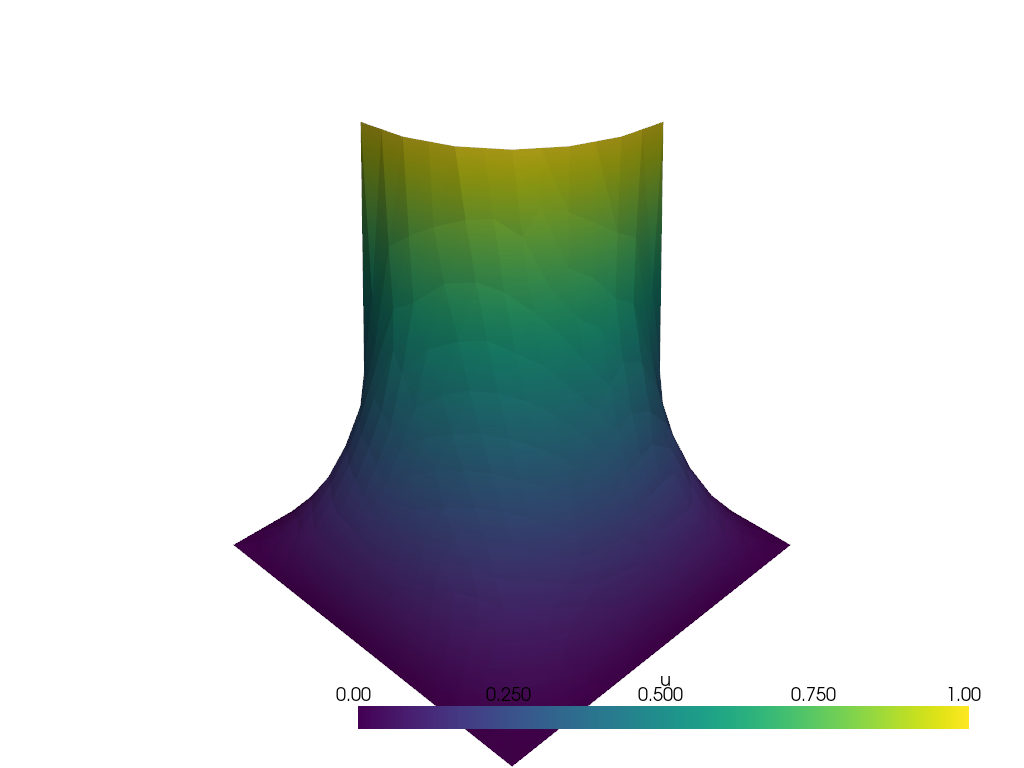

In [33]:
cells, types, x = dolfinx.plot.vtk_mesh(W)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.show()

THIS RUNS BUT I DONT KNOW THE CAPACITANCE... WE NEED TO FIGURE OUT HOW TO GET IT (I THINK ITS FROM THE ASSIGNMENT 3 EXERCISE 2)

In [34]:
bb_tree = dolfinx.geometry.bb_tree(msh, msh.geometry.dim-1)
x0 = np.array([[0.9, 0.9, 0.]], dtype=np.float64)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, x0)
cell = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates, x0).array
uh.eval(x0, cell)

array([0.01865934])